In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere
from tqdm.notebook import tqdm

DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Ori2_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

(1000, 176, 384)
(1000, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [3]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [4]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [5]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:34,  1.12s/it]

Training Loss: 660.927716486156 Validation Loss: 201.65472745522857


  4%|▎         | 11/300 [00:12<05:05,  1.06s/it]

Training Loss: 105.67581911780871 Validation Loss: 26.286354812793434


  7%|▋         | 21/300 [00:22<04:45,  1.02s/it]

Training Loss: 69.42903447989374 Validation Loss: 25.40648751333356


 10%|█         | 31/300 [00:32<04:29,  1.00s/it]

Training Loss: 71.00749787630048 Validation Loss: 20.317655811086297


 14%|█▎        | 41/300 [00:42<04:25,  1.03s/it]

Training Loss: 93.79316326451954 Validation Loss: 20.321768033172702


 17%|█▋        | 51/300 [00:52<04:11,  1.01s/it]

Training Loss: 54.739685342879966 Validation Loss: 20.10360385221429


 20%|██        | 61/300 [01:03<04:08,  1.04s/it]

Training Loss: 47.34076049167197 Validation Loss: 19.082747387699783


 24%|██▎       | 71/300 [01:13<03:56,  1.03s/it]

Training Loss: 45.49772955616936 Validation Loss: 18.029559558723122


 27%|██▋       | 81/300 [01:23<03:46,  1.03s/it]

Training Loss: 48.8879285226576 Validation Loss: 18.885247800964862


 30%|███       | 91/300 [01:33<03:34,  1.02s/it]

Training Loss: 43.66855948061857 Validation Loss: 17.88995784614235


 34%|███▎      | 101/300 [01:44<03:25,  1.03s/it]

Training Loss: 42.67983334755991 Validation Loss: 19.414507301757112


 37%|███▋      | 111/300 [01:54<03:13,  1.02s/it]

Training Loss: 40.72826913854806 Validation Loss: 19.645428078714758


 40%|████      | 121/300 [02:04<03:00,  1.01s/it]

Training Loss: 34.952508371003205 Validation Loss: 19.29355117538944


 44%|████▎     | 131/300 [02:14<02:53,  1.03s/it]

Training Loss: 33.510846468561795 Validation Loss: 18.06189721217379


 47%|████▋     | 141/300 [02:24<02:44,  1.04s/it]

Training Loss: 31.589520383276977 Validation Loss: 18.336457368917763


 50%|█████     | 151/300 [02:35<02:33,  1.03s/it]

Training Loss: 35.6886995480163 Validation Loss: 18.673569656792097


 54%|█████▎    | 161/300 [02:45<02:24,  1.04s/it]

Training Loss: 28.72666773176752 Validation Loss: 19.118191151879728


 57%|█████▋    | 171/300 [02:55<02:10,  1.01s/it]

Training Loss: 26.952798509257264 Validation Loss: 20.5097541611176


 60%|██████    | 181/300 [03:05<02:03,  1.04s/it]

Training Loss: 26.944838622410316 Validation Loss: 21.544401166262105


 64%|██████▎   | 191/300 [03:15<01:51,  1.02s/it]

Training Loss: 24.79272609646432 Validation Loss: 20.689719485584646


 67%|██████▋   | 201/300 [03:26<01:42,  1.04s/it]

Training Loss: 23.413727501785615 Validation Loss: 20.5517283345107


 70%|███████   | 211/300 [03:36<01:31,  1.02s/it]

Training Loss: 22.208307852924918 Validation Loss: 21.669613854959607


 74%|███████▎  | 221/300 [03:46<01:21,  1.03s/it]

Training Loss: 21.383629075542558 Validation Loss: 21.71175932441838


 77%|███████▋  | 231/300 [03:57<01:06,  1.04it/s]

Training Loss: 20.750994900619844 Validation Loss: 21.03252752730623


 80%|████████  | 241/300 [04:07<00:59,  1.01s/it]

Training Loss: 19.710313952538854 Validation Loss: 20.44990166730713


 84%|████████▎ | 251/300 [04:17<00:50,  1.04s/it]

Training Loss: 18.726986838213634 Validation Loss: 19.995131505071186


 87%|████████▋ | 261/300 [04:27<00:40,  1.03s/it]

Training Loss: 18.250606016314123 Validation Loss: 19.539914821798448


 90%|█████████ | 271/300 [04:38<00:29,  1.03s/it]

Training Loss: 17.724999221303733 Validation Loss: 18.63978664256865


 94%|█████████▎| 281/300 [04:48<00:19,  1.04s/it]

Training Loss: 17.370544508099556 Validation Loss: 17.414193354547024


 97%|█████████▋| 291/300 [04:58<00:09,  1.04s/it]

Training Loss: 16.782794978716993 Validation Loss: 16.735097372089513


100%|██████████| 300/300 [05:08<00:00,  1.03s/it]


In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.961010894632988
(128, 2)
(128, 2)


<IPython.core.display.Javascript object>


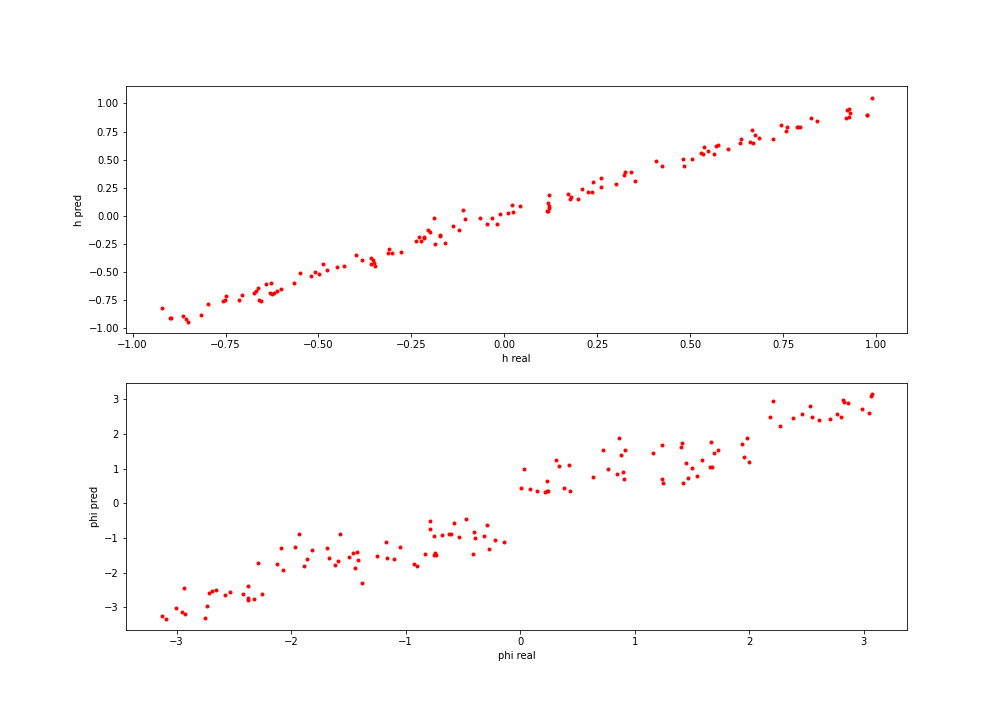

In [10]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(14, 10))
#inf_list = ['r_s', 'l_t', 'r_t', 'r_d', 'r_tu', 'l_d']

# ax_h = plt.subplot(121)
# ax_h.scatter(h_lab, h_out, c='red', marker='.')
# ax_h.set_xlabel('h real')
# ax_h.set_ylabel('h pred')

# ax_p = plt.subplot(122)
# ax_p.scatter(phi_lab, phi_out, c='red', marker='.')
# ax_p.set_xlabel('phi real')
# ax_p.set_ylabel('phi pred')

ax_d = plt.subplot(211)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('h real')
ax_d.set_ylabel('h pred')

ax_t = plt.subplot(212)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('phi real')
ax_t.set_ylabel('phi pred')

# ax_t = plt.subplot(326)
# ax_t.scatter(y[:,5], output[:,5], c='red', marker='.')
# ax_t.set_xlabel('dendrite length real')
# ax_t.set_ylabel('dendrite length pred')

plt.show()

<IPython.core.display.Javascript object>


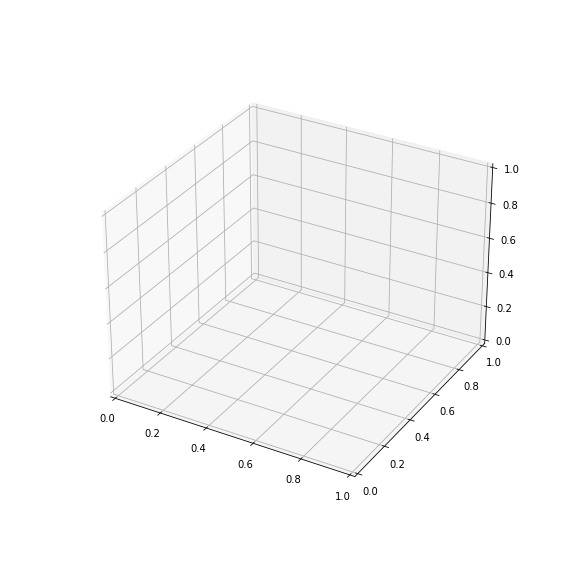

IndexError: index 2 is out of bounds for axis 1 with size 2

In [8]:
%matplotlib notebook

idx = 0#[0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(y[idx,0], y[idx,1], y[idx,2], c='green', marker='.')
ax.scatter3D(output[idx,0], output[idx,1], output[idx,2], c='red', marker='^')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()